# Import Library

In [ ]:
import os
import shutil
import zipfile
import numpy as np
import tensorflow as tf
import cv2
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from glob import glob
from zipfile import ZipFile
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras import layers, models, optimizers
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications.mobilenet import MobileNet, preprocess_input, decode_predictions

# Extract the dataset

In [ ]:
with ZipFile('D:/Data/Irzan/ICIMCIS/waste-classification-data-v2.zip', 'r') as zipObject:
   listOfFileNames = zipObject.namelist()
   for fileName in listOfFileNames:
     zipObject.extract(fileName, 'D:/Data/Irzan/ICIMCIS/')

# Move the data into raw foler

In [ ]:
for tt in os.listdir(os.path.join('D:/Data/Irzan/ICIMCIS', 'DATASET')):
  tt_path = os.path.join('D:/Data/Irzan/ICIMCIS', 'DATASET', tt)
  for cc in os.listdir(tt_path):
    cc_path = os.path.join(tt_path, cc)
    for im in os.listdir(cc_path):
      if cc == 'N':
        shutil.move(os.path.join(cc_path, im), os.path.join('D:/Data/Irzan/ICIMCIS/raw', 'non-organic'))
      if cc == 'O':
        shutil.move(os.path.join(cc_path, im), os.path.join('D:/Data/Irzan/ICIMCIS/raw', 'organic'))
      if cc == 'R':
        shutil.move(os.path.join(cc_path, im), os.path.join('D:/Data/Irzan/ICIMCIS/raw', 'recycleable'))

In [ ]:
DATADIR = os.path.join('D:/Data/Irzan/ICIMCIS')
RAWDATADIR = os.path.join(DATADIR, 'raw')
TRAINDIR = os.path.join(DATADIR, 'train')
VALDIR = os.path.join(DATADIR, 'val')
TESTDIR = os.path.join(DATADIR, 'test')
MODEL_NAME = 'mobilenet_v1'

img_width, img_height = (224, 224)
img_channel = 3
type_list = ['non-organic', 'organic', 'recycleable']

# Check the amount of data

In [ ]:
labels = []

for class_folder in os.listdir(RAWDATADIR):
    for im in os.listdir(os.path.join(RAWDATADIR, class_folder)):
        labels.append(class_folder)

In [ ]:
unique_label, unique_count = np.unique(labels, return_counts=True)
labels_dict = dict(zip(unique_label, unique_count))

labels_dict

{'non-organic': 3244, 'organic': 13966, 'recycleable': 8264}

# Data Balancing

In [ ]:
non_organic_delete = os.listdir(os.path.join(RAWDATADIR, 'non-organic'))[:1744]

for files in non_organic_delete:
    os.remove(os.path.join(RAWDATADIR, 'non-organic', files))

In [ ]:
organic_delete = os.listdir(os.path.join(RAWDATADIR, 'organic'))[:12466]

for files in organic_delete:
    os.remove(os.path.join(RAWDATADIR, 'organic', files))

In [ ]:
recycleable_delete = os.listdir(os.path.join(RAWDATADIR, 'recycleable'))[:6764]

for files in recycleable_delete:
    os.remove(os.path.join(RAWDATADIR, 'recycleable', files))

# Recheck amount of data

In [ ]:
labels = []

for class_folder in os.listdir(RAWDATADIR):
    for im in os.listdir(os.path.join(RAWDATADIR, class_folder)):
        labels.append(class_folder)

In [ ]:
unique_label, unique_count = np.unique(labels, return_counts=True)
labels_dict = dict(zip(unique_label, unique_count))

labels_dict

{'non-organic': 1500, 'organic': 1500, 'recycleable': 1500}

# Making Train, Test and Val Folder

In [ ]:
for folder in ['train', 'test', 'val']:
    if os.path.isdir(os.path.join(DATADIR, folder)):
        print('{} exists' .format(os.path.join(DATADIR, folder)))
    else:
        os.mkdir(os.path.join(DATADIR, folder))

In [ ]:
for folder in ['train', 'test', 'val']:
    for key in labels_dict.keys():
        os.mkdir(os.path.join(DATADIR, folder, key))

# Move the respective data into the train, val, test folders

In [ ]:
images = []

for class_folder in tqdm(os.listdir(RAWDATADIR)):
    for im in os.listdir(os.path.join(RAWDATADIR, class_folder)):
        images.append([im, class_folder])

100%|██████████| 3/3 [00:00<00:00, 15.19it/s]


In [ ]:
images_df = pd.DataFrame(images)
images_df.columns = ['filename', 'labels']

In [ ]:
np.unique(images_df['labels'], return_counts=True)

(array(['non-organic', 'organic', 'recycleable'], dtype=object),
 array([1500, 1500, 1500], dtype=int64))

In [ ]:
X = images_df['filename']
y = images_df['labels']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y,
                                                    shuffle=True,
                                                    random_state=42)

In [ ]:
X_train_val, X_val, y_train_val, y_val = train_test_split(X_train, y_train, test_size=0.2,
                                                          stratify=y_train,
                                                          shuffle=True, 
                                                          random_state=42)

In [ ]:
for x, y in tqdm(zip(X_train_val, y_train_val), total=len(X_train_val)):
    src = os.path.join(RAWDATADIR, y, x)
    dst = os.path.join(DATADIR, 'train', y)
    shutil.copy(src, dst)

100%|██████████| 2880/2880 [00:02<00:00, 1037.58it/s]


In [ ]:
for x, y in tqdm(zip(X_val, y_val), total=len(X_val)):
    src = os.path.join(RAWDATADIR, y, x)
    dst = os.path.join(DATADIR, 'val', y)
    shutil.copy(src, dst)

100%|██████████| 720/720 [00:00<00:00, 978.22it/s] 


In [ ]:
for x, y in tqdm(zip(X_test, y_test), total=len(X_test)):
    src = os.path.join(RAWDATADIR, y, x)
    dst = os.path.join(DATADIR, 'test', y)
    shutil.copy(src, dst)

100%|██████████| 900/900 [00:01<00:00, 627.64it/s]


# Image Augmentation

In [ ]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rescale=1./255,
                                   rotation_range=45,
                                   brightness_range=(1.0, 1.5),
                                   shear_range=0.3,
                                   zoom_range=0.3,
                                   horizontal_flip=True,
                                   fill_mode='reflect')

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, rescale=1./255)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(directory=TRAINDIR,
                                                    target_size=(img_width, img_height),
                                                    color_mode='rgb',
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    shuffle=True)
val_generator = val_datagen.flow_from_directory(directory=VALDIR,
                                                target_size=(img_width, img_height),
                                                color_mode='rgb',
                                                class_mode='categorical',
                                                shuffle=True)
test_generator = test_datagen.flow_from_directory(directory=TESTDIR,
                                                  target_size=(img_width, img_height),
                                                  color_mode='rgb',
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 2880 images belonging to 3 classes.
Found 720 images belonging to 3 classes.
Found 900 images belonging to 3 classes.


# Making Mobilenet-V1 based model

In [ ]:
mobilenet = tf.keras.applications.mobilenet.MobileNet(include_top=False,
                                                      weights='imagenet', dropout=0.4,
                                                      input_shape=(img_width, img_height, img_channel))

# Make all the layer into trainable

In [ ]:
for layer in mobilenet.layers:
    layer.trainable = True

# Adding GlobalAveragePooling and Output Layer

In [ ]:
model = tf.keras.models.Sequential([
    mobilenet,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3075      
Total params: 3,231,939
Trainable params: 3,210,051
Non-trainable params: 21,888
_________________________________________________________________


In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

# Train the model

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min' , patience=5)
start = time.time()
history = model.fit(
      train_generator,
      epochs=30, # tambahkan eposchs jika akurasi model belum optimal
      validation_data=val_generator, # menampilkan akurasi pengujian data validasi
      verbose=1,
      callbacks=callback
)
end = time.time()

Epoch 1/30
90/90 [==============================] - 44s 490ms/step - loss: 0.5549 - accuracy: 0.7802 - val_loss: 2.0307 - val_accuracy: 0.3333
Epoch 2/30
90/90 [==============================] - 43s 480ms/step - loss: 0.3220 - accuracy: 0.8833 - val_loss: 1.1955 - val_accuracy: 0.4944
Epoch 3/30
90/90 [==============================] - 44s 481ms/step - loss: 0.2495 - accuracy: 0.9066 - val_loss: 1.5090 - val_accuracy: 0.4972
Epoch 4/30
90/90 [==============================] - 44s 482ms/step - loss: 0.2068 - accuracy: 0.9240 - val_loss: 0.4964 - val_accuracy: 0.7917
Epoch 5/30
90/90 [==============================] - 44s 481ms/step - loss: 0.1750 - accuracy: 0.9316 - val_loss: 0.4020 - val_accuracy: 0.8333
Epoch 6/30
90/90 [==============================] - 44s 486ms/step - loss: 0.1611 - accuracy: 0.9427 - val_loss: 0.3864 - val_accuracy: 0.8736
Epoch 7/30
90/90 [==============================] - 44s 483ms/step - loss: 0.1261 - accuracy: 0.9528 - val_loss: 0.3526 - val_accuracy: 0.8681

In [ ]:
print(end-start)

880.6975741386414


# Evaluate the model

In [ ]:
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())   

In [ ]:
model.evaluate(test_generator, return_dict=True)

29/29 [==============================] - 2s 65ms/step - loss: 0.2811 - accuracy: 0.9100


{'loss': 0.28108713030815125, 'accuracy': 0.9100000262260437}

In [ ]:
import sklearn.metrics as metrics

y_pred_ohe = model.predict(test_generator)  # shape=(n_samples, 12)
y_pred_labels = np.argmax(y_pred_ohe, axis=1)  # only necessary if output has one-hot-encoding, shape=(n_samples)

confusion_matrix = metrics.confusion_matrix(y_true=test_generator.classes, y_pred=y_pred_labels)  # shape=(12, 12)

In [ ]:
confusion_matrix

array([[274,  16,  10],
       [ 16, 270,  14],
       [ 19,   6, 275]], dtype=int64)

<AxesSubplot:>

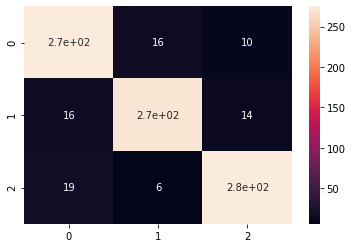

In [ ]:
import seaborn as sns
sns.heatmap(confusion_matrix, annot=True)

# Making Plot for model history

In [ ]:
def graph(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

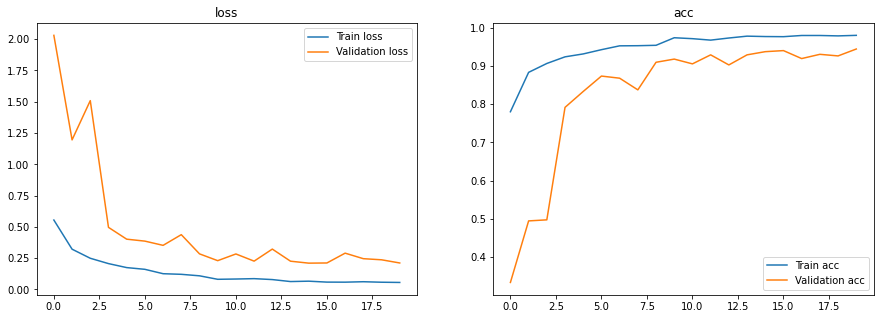

In [ ]:
graph(history)

# Saving the model

In [ ]:
# Convert model to tflite.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\Admin\AppData\Local\Temp\tmpm8n9aq5w\assets


In [ ]:
with tf.io.gfile.GFile('D:/Data/Irzan/ICIMCIS/model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
model.save("D:/Data/Irzan/ICIMCIS/model.h5")
model.save_weights("D:/Data/Irzan/ICIMCIS/weight.h5")